# FinanceBot Workflow
The purpose of this file is to ensure that all dependencies are correctly installed.

In [11]:
from _functions import *  # Ensure this function exists

import pandas as pd
import matplotlib.pyplot as plt
import copy
from typing import TypedDict, List
from langchain_openai import ChatOpenAI  # Correct import for ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
import operator
from pydantic import BaseModel
from langchain.schema import HumanMessage

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS# Use the correct import path or alias if needed

llm = ChatOpenAI(temperature=0.7)

# FinanceBot Workflow
The purpose of this file is to ensure that all dependencies are correctly installed.

## Create State Graph
Create this graph to better keep track the information between states

In [12]:
# Graph State Definition
class State(TypedDict):
    ticker: Annotated[List[str], operator.add]  # Corrected type hint with AnnotatedKey
    data: pd.DataFrame
    arts: pd.DataFrame
    plot: plt.Figure
    forecast: pd.DataFrame
    response: str
    intro: str
    summary: str

In [13]:
def stock_info_node(state: State) -> State:
    """Fetches a brief company introduction using the ticker."""
    ticker = state.get("ticker", ["GM"])  # Default to GM
    intro = llm.invoke(f"You are to give a brief synopsis of the company associated with the ticker {ticker[0]}. \
                       Use Axios-style bullet points with emojis about key aspects such as the business sector \
                       and some historical information.")
    
    new_state = copy.deepcopy(state)
    new_state['intro'] = intro.content
    return new_state

In [14]:
search_tool = TavilySearchResults(max_results=3)

def search_ticker(state: State) -> State:
    ticker = state["ticker"]
    query = f"I need the latest company news about the company with stock ticker: {', '.join(ticker)}"
    search_results = search_tool.run(query)
    return {"response": search_results}

def process_data(state: State) -> State:
    response = state["response"]
    # Assuming we extract structured data from the response
    df = pd.DataFrame([{"Ticker": t, "Data": response} for t in state["ticker"]])
    return {"arts": df}

def generate_insights(state: State) -> State:
    response = state["response"]
    messages = [HumanMessage(content=f"Summarize the following financial data:{response}. Please do so in the style of \
                             Axios. You are more than welcome to use emojis to add some color here, use several different emojis.\
                             Please separate results to be positive and negaitve about the outlook.")]
    summary = llm(messages)
    return {"summary": summary.content}

In [15]:
def stock_data_node(state: State) -> State:
    """Fetches stock data for the given ticker."""
    ticker = state['ticker'][0]  # Default to GM
    stock_data = get_stock_data(ticker=ticker)  # Ensure function exists

    new_state = copy.deepcopy(state)
    new_state['data'] = stock_data  # Avoid unnecessary JSON serialization
    return new_state

In [ ]:
def forecast_node(state: State) -> State:
    """
    Generates forecasts using ARIMA and AutoETS models on the 'close' prices and plots these forecasts 
    alongside the actual data.
    
    Expects state['data'] to be a DataFrame with at least the following columns:
      - 'timestamp': Unix timestamp in milliseconds
      - 'close': observed close prices of the stock
    
    The forecast horizon is set to 20 periods. The resulting matplotlib Figure is stored in state['plot'].
    """

    # Extract and prepare data focusing on 'timestamp' and 'close'
    df = state['data'][['timestamp', 'close']].copy()
    
    # Convert timestamp from milliseconds since epoch to datetime and sort the data
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.sort_values('timestamp')
    
    # Rename columns to match statsforecast expected format: 'ds' for datetime, 'y' for the observed value
    df = df.rename(columns={'timestamp': 'ds', 'close': 'y'})
    
    # Add a unique identifier for the time series using the first ticker symbol
    df['unique_id'] = state['ticker'][0]
    
    # Set forecast horizon (20 periods ahead)
    h = 40

    forecasts = get_arima_predictions(df, h)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the actual time series data
    ax.plot(df['ds'], df['y'], label='Actual', marker='o')
    
    # Plot the forecasted values from ARIMA and AutoETS.
    # The forecasts DataFrame is expected to include columns 'AutoARIMA' and 'AutoETS', along with 'ds'
    ax.plot(forecasts['ds'], forecasts['ARIMA'], label='ARIMA Forecast', linestyle='--', marker='x')
    ax.plot(forecasts['ds'], forecasts['NBEATS'], label='NBEATS Forecast', linestyle='--', marker='o')
    ax.plot(forecasts['ds'], forecasts['NHITS'], label='NHITS Forecast', linestyle='--', marker='s')
    
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Close Price')
    ax.set_title(f'Forecasts for {state['ticker'][0]}')
    ax.legend()
    
    new_state = copy.deepcopy(state)
    new_state['plot'] = fig
    return new_state


In [17]:
# Initialize LangGraph Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("get_data", stock_data_node)
workflow.add_node("plot_data", forecast_node)
workflow.add_node("introduction", stock_info_node)

workflow.add_node("search", search_ticker)  # Fixed node reference
workflow.add_node("process", process_data)  # Fixed node reference
workflow.add_node("insight", generate_insights)  # Fixed node reference


workflow.add_edge(START, "get_data")
workflow.add_edge("get_data", "plot_data")
workflow.add_edge("plot_data", END)

workflow.add_edge(START, "search")
workflow.add_edge("search", "process")
workflow.add_edge("process", "insight")
workflow.add_edge("insight", END)


workflow.add_edge(START, "introduction")
workflow.add_edge("introduction", END)

# Ensure the workflow is compiled before invoking
chain = workflow.compile()

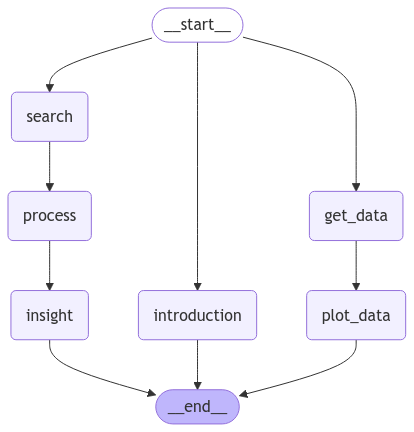

In [18]:
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
9.7 K     Non-trainable params
2.6 M     Total params
10.571    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-

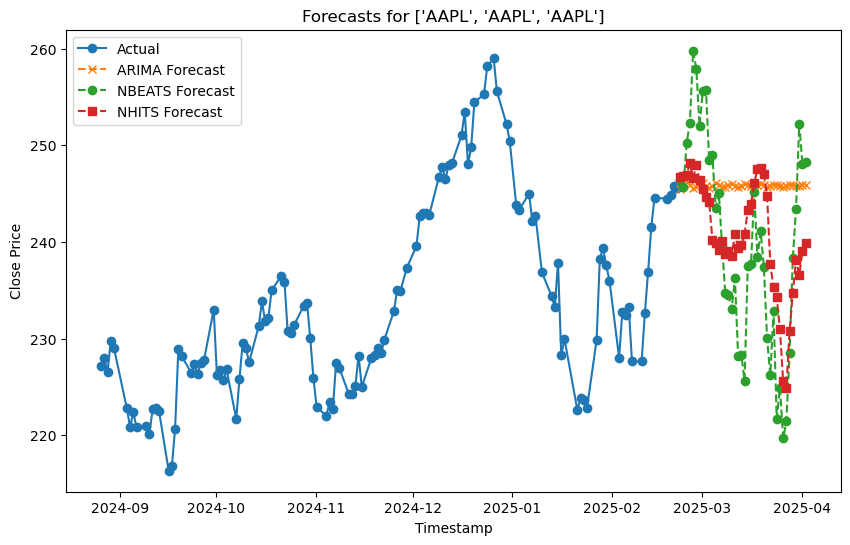

In [19]:
# Ensure the workflow is compiled before invoking
chain = workflow.compile()

# Invoke the workflow with the correct input format
state = chain.invoke({"ticker": ["AAPL"]})

- 🍏 Apple Inc. is a multinational technology company known for its iconic hardware products and software services
- 📱 Founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne
- 💻 Initially focused on personal computers, Apple has since expanded to include consumer electronics, software, and digital services
- 🌍 One of the world's largest technology companies by revenue and market capitalization
- 🚀 Known for its innovation and design-driven approach to product development
- 🍎 Key products include the iPhone, iPad, Mac, Apple Watch, and services like Apple Music and iCloud


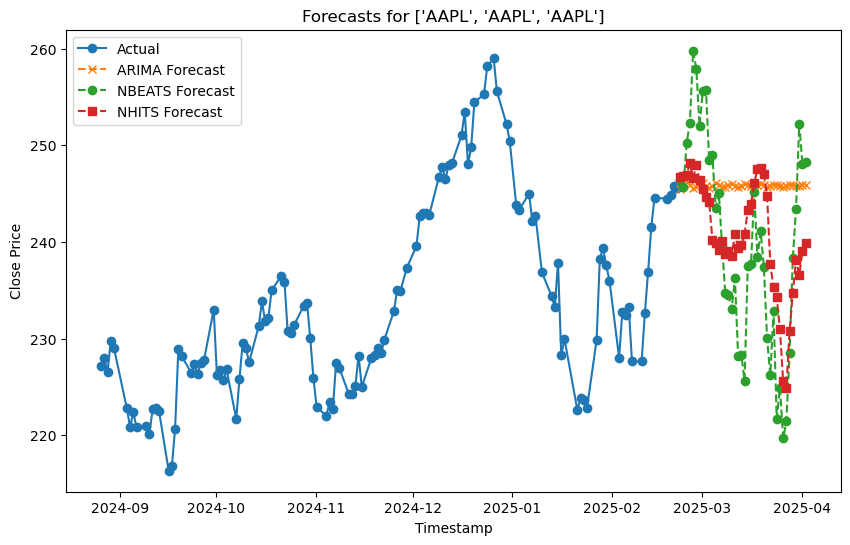

🚀 Positive Outlook:
- Apple Inc. has launched significant updates across its product lines, including powerful new AI features in Final Cut Pro for Mac and special-edition AirPods 4 for Chinese New Year.
- The company continuously supports innovation through the development of hardware and software, integrating new technologies like AI and augmented reality to enhance user experiences.

📉 Negative Outlook:
- The Home Office has ordered Apple to let it access users' encrypted files, which could raise concerns about privacy and security.
- While Apple is a strong player in the market, other companies like Alphabet are also making strides and could potentially join the $3 trillion club, posing competition for Apple.


In [20]:
print(state['intro'])
display(state['plot'])
print(state['summary'])